In [1]:
from lib.am_utils import *
import lib.consts as c
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.width', 1000)

#### The Hamiltonian
\begin{equation}
H=H_\text{rot}+H_\text{hf}+H_\text{S}+H_\text{Z}
\end{equation}
where
\begin{equation}
H_\text{rot} = B_v\mathbf{N}^2-D_v\mathbf{N}^2\mathbf{N}^2
\end{equation}

\begin{equation}
H_\text{hf} = \sum_{i=1}^2\mathbf{V}_i\cdot\mathbf{Q}_i + \sum_{i=1}^2c_i\mathbf{N}\cdot\mathbf{I}_i + c_3\mathbf{I}_i\cdot\mathbf{T}\cdot\mathbf{I}_2+c_4\mathbf{I}_1\cdot\mathbf{I}_2
\end{equation}

\begin{equation}
H_S = -\mathbf{\mu}\cdot\mathbf{E}
\end{equation}

\begin{equation}
H_Z = -g_r\mu_N\mathbf{N}\cdot\mathbf{B} - \sum_{i=1}^2g_i\mu_N\mathbf{I}_i\cdot\mathbf{B}(1-\sigma_i)
\end{equation}

#### Parameters

In [2]:
# make everything in kHz
p0 = {'I1': 3/2,
      'I2': 7/2,
      'N': arange(0,1),
      'g1': 1.478,
      'g2': 0.748,
      'Bv': 1.7396*1e6, # MHz
      'eQq1': -0.097*1e3, # MHz
      'eQq2': 0.15*1e3, # MHz
      'sig1': 639.2 / 1e6, # ppm
      'sig2': 6278.7 / 1e6, # ppm
      'c1': 14.2*1e-3, # Hz
      'c2': 854.5*1e-3, # Hz
      'c3': 105.6*1e-3, # Hz
      'c4': 3941.8*1e-3, # Hz
      'gr': 0, # 0.0144 ##
      'mu': 4.6*3.33564*1e-28/c.h, # D
      'muN': 5.050783699e-27 * 1e-4 * 1e-3/ c.h, # J/T
      'muE': 4.6*(3.33564e-30), # Debye
      'alpha_p': 1872.1153,
      'alpha_s': 467.0375,
      'E_td_00': np.linspace(0,0,1), # 1000
      'trap_pol': np.array([[0],[1],[0]]),
      'E_dc': np.array([0,0,0]), # V/cm
      'B': np.linspace(0,0,1)}

#### Create Hamiltonian
Everything ultimately in uncoupled basis

In [30]:
def dm_ops_sph(b,j='n'):
    _,_,delta_spec = get_spectators(b,[j,'m_'+j],mat=True)
    
    f1 = b_op(lambda b1,b2,j: (-1)**(b1['m_'+j])*np.sqrt((2*b1[j]+1)*(2*b2[j]+1)), b, 0,j) 
    f2 = b_op(lambda b1,b2,j: py3nj.wigner3j(b1[j], int(2*1), b2[j],
                                             0,     0,        0), b,1,j)
    
    cg_z = b_op(lambda b1,b2,j,q: py3nj.wigner3j(b1[j],    int(2*1),   b2[j],
                                              -b1['m_'+j], int(2*q), b2['m_'+j]), b,1,j,0)
    cg_r1 = b_op(lambda b1,b2,j,q: py3nj.wigner3j(b1[j],   int(2*1),   b2[j],
                                              -b1['m_'+j], int(2*q), b2['m_'+j]), b,1,j,1)
    cg_r2 = b_op(lambda b1,b2,j,q: py3nj.wigner3j(b1[j],   int(2*1),   b2[j],
                                              -b1['m_'+j], int(2*q), b2['m_'+j]), b,1,j,-1)
        
    M_z = delta_spec*f1*f2*cg_z
    M_r1 = delta_spec*f1*f2*cg_r1 # sig+
    M_r2 = delta_spec*f1*f2*cg_r2 # sig-

    return (M_r2,M_z,M_r1)

def H_mol(p):
    
    # create basis
    b_uc = am_basis([['i1',p['I1'],1],['i2',p['I2'],1],['n',p['N'],1]])
    b_sc, M_uc2sc = couple_basis(b_uc,['i1','i2','i'])
    b_fic, M_uc2fic = ([], [])
    for i,f in zip(['i1','i2'],['f1','f2']):
        b_t, M_t = couple_basis(b_uc,[i,'n',f])
        b_fic.append(b_t)
        M_uc2fic.append(M_t)
    b_fc, M_sc2fc = couple_basis(b_sc,['i','n','f'])
    M_uc2fc = M_sc2fc@M_uc2sc    
    

    H_hf_eQi_fic, H_hf_eQi_fc, H_hf_eQi_uc = ([],[],[])
    for ind,j in enumerate(zip(['i1','i2'],['f1','f2'])):
        i,n,f = (j[0],'n',j[1])
        v = b_fic[ind].v.copy()
        C = np.diag(op(b_fic[ind],i+'*'+n+','+f))
        H_hf_eQi_fic.append(np.diag(((3*C*C + 3/2*C - v[i]*(v[i]+1)*v[n]*(v[n]+1)) /
                      (2*v[i]*(2*v[i]-1)*(2*v[n]-1)*(2*v[n]+3)))))
        #H_hf_eQi_fic.append(np.diag(((3/2*C*(2*C+1) - v[i]*(v[i]+1)*v[n]*(v[n]+1)) /
        #              (2*v[i]*(2*v[i]-1)*(2*v[n]-1)*(2*v[n]+3)))))
        H_hf_eQi_uc.append(np.transpose(M_uc2fic[ind])@H_hf_eQi_fic[ind]@M_uc2fic[ind])
        H_hf_eQi_fc.append(M_uc2fc@np.transpose(M_uc2fic[ind])@H_hf_eQi_fic[ind]@
                             M_uc2fic[ind]@np.transpose(M_uc2fc))
    H_hf_eQ_uc = - p['eQq1']*H_hf_eQi_uc[0] - p['eQq2']*H_hf_eQi_uc[1]

    H_rot_uc = p['Bv'] * op(b_uc,'n^2')
    H_z_rot_uc = -p['gr']*p['muN'] * op(b_uc,'m_n')
    H_z_nuc_uc = -p['g1']*p['muN']*(1-p['sig1']) * op(b_uc,'m_i1') \
                    -p['g2']*p['muN']*(1-p['sig2']) * op(b_uc,'m_i2')

    H_hf_sr_uc = (p['c1'] * np.transpose(M_uc2fic[0])@op(b_fic[0],'i1*n,f1')@M_uc2fic[0] + \
                  p['c2'] * np.transpose(M_uc2fic[1])@op(b_fic[1],'i2*n,f2')@M_uc2fic[1])
    H_hf_ss_uc = p['c4'] * np.transpose(M_uc2fc)@op(b_fc,'i1*i2,i')@M_uc2fc
    
    def H_ls(b,a_p,a_s,E00,pol):
        
        def rot_state_op(b,M):
            Mrot = b_op(lambda b1,b2: ((b1['n']==0)&(b2['n']==0))*0 + 
            (((b1['n']==1)&(b2['n']==1)&(b1['m_n']==-1)&(b2['m_n']==-1))*M[0,0] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==-1)&(b2['m_n']==0))*M[0,1] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==-1)&(b2['m_n']==1))*M[0,2] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==0)&(b2['m_n']==-1))*M[1,0] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==0)&(b2['m_n']==0))*M[1,1] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==0)&(b2['m_n']==1))*M[1,2] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==1)&(b2['m_n']==-1))*M[2,0] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==1)&(b2['m_n']==0))*M[2,1] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==1)&(b2['m_n']==1))*M[2,2]),b,0)
            return Mrot
        
        _,_,delta_spec = get_spectators(b,['n','m_n'],mat=True)
        a_00 = 1/3 * (a_p + 2*a_s)
        
        a_23 = (2*a_p+3*a_s)/5
        a_32 = (3*a_p+2*a_s)/5        
        a_14 = (a_p+4*a_s)/5
        a_11 = (a_p-a_s)/5
        
        MM = np.zeros((3,3,3,3),dtype = 'complex_')
        MM[0,0] = np.array([[a_23,0,0],[0,a_23,0],[0,0,a_14]])
        MM[0,1] = np.array([[0,0,1j*a_11/np.sqrt(2)],[0,0,a_11/np.sqrt(2)],[1j*a_11/np.sqrt(2),a_11/np.sqrt(2),0]])
        MM[0,2] = np.array([[a_11,-1j*a_11,0],[-1j*a_11,-a_11,0],[0,0,0]])
        MM[1,0] = np.array([[0,0,-1j*a_11/np.sqrt(2)],[0,0,a_11/np.sqrt(2)],[-1j*a_11/np.sqrt(2),a_11/np.sqrt(2),0]])
        MM[1,1] = np.array([[a_14,0,0],[0,a_14,0],[0,0,a_32]])
        MM[1,2] = np.array([[0,0,-1j*a_11/np.sqrt(2)],[0,0,-a_11/np.sqrt(2)],[-1j*a_11/np.sqrt(2),-a_11/np.sqrt(2),0]])
        MM[2,0] = np.array([[a_11,1j*a_11,0],[1j*a_11,-a_11,0],[0,0,0]])
        MM[2,1] = np.array([[0,0,1j*a_11/np.sqrt(2)],[0,0,-a_11/np.sqrt(2)],[1j*a_11/np.sqrt(2),-a_11/np.sqrt(2),0]])
        MM[2,2] = np.array([[a_23,0,0],[0,a_23,0],[0,0,a_14]])   
        MM = np.einsum('ijkl->klij',MM)
        for i in range(3):
            for j in range(3):
                np.fill_diagonal(MM[i,j,:,:],np.diagonal(MM[i,j])-a_00)   
#                 np.fill_diagonal(MM[i,j,:,:],np.diagonal(MM[i,j])-a_00)        
        if pol.shape == (3,1):
            P = np.einsum('ijkl,jm->ikl',MM,pol)
            Q = np.einsum('ij,jlm->ilm',np.conjugate(pol.T),P)
        else:
            P = np.einsum('ijkl,jm->ikl',MM,pol.T)
            Q = np.einsum('ij,jlm->ilm',np.conjugate(pol),P)
        Q = Q / np.linalg.norm(pol)
        mat = rot_state_op(b,Q[0,:])
        
        return delta_spec*mat*E00/a_00     

    H_ls_uc = -H_ls(b_uc,p['alpha_p'],p['alpha_s'],1,p['trap_pol'])
    
    if np.linalg.norm(p['E_dc']) > 0.001:
        M_r2,M_z,M_r1 = dm_ops_sph(b_uc)
        M_x = (M_r1 + np.conjugate(M_r2.T))/np.sqrt(2)
        M_y = (M_r1 - np.conjugate(M_r2.T))*1j/np.sqrt(2)
        H_S_uc = - p['muE'] * (p['E_dc'][0] * M_x + p['E_dc'][1] * M_y + p['E_dc'][2] * M_z)
    else:
        H_S_uc = 0
    
    if not(p['B'].shape[0] > 1 & p['E_td_00'].shape[0] > 1):
        H_B_tot_uc = (H_rot_uc + H_hf_sr_uc + H_hf_ss_uc + H_hf_eQ_uc + H_ls_uc*p['E_td_00'][:, np.newaxis, np.newaxis] +
            (H_z_rot_uc + H_z_nuc_uc) * p['B'][:, np.newaxis, np.newaxis]) + H_S_uc
    else:
        raise ValueError('cannot scan multiple axes')
        
    return np.real(H_B_tot_uc), b_uc

Helper functions

In [4]:
def map2basis(Tv):
    # finds the "closest" uncoupled basis index value
    M = np.zeros(Tv.shape)
    inds = []
    for j in range(Tv.shape[0]):
        v = Tv[:,j]
        v_amp = np.abs(v)
        ind = np.argmax(v_amp)
        M[ind,j] = 1
        inds.append(ind)
    return M, np.array(inds)

def disp_vec(buc, Evv, qn_uc, b_print=True):
    # display components corresponding to uc basis
    if type(qn_uc) == list:
        _,inds_vind2uc = map2basis(Evv)
        uc_ind = b_uc.get_ind(*qn_uc)[0]
        ev_ind = np.where(inds_vind2uc==uc_ind)[0][0]
        vec_amps = Evv[:,ev_ind] * Evv[:,ev_ind]
        vec_amps0 = Evv[:,ev_ind]
        amp_argsort = np.squeeze(np.argsort(-vec_amps,axis=0))
        pos = np.argmax(np.squeeze(-np.sort(-vec_amps,axis=0)) < 0.0001)
        ddf = b_uc.v.loc[amp_argsort[0:pos],['m_i1','m_i2','n','m_n']]
        ddf['amps'] =  np.squeeze(vec_amps0[amp_argsort[0:pos]])
    elif type(qn_uc) == int:
        vec_amps = Evv[:,qn_uc] * Evv[:,qn_uc]        
        vec_amps0 = Evv[:,qn_uc]
        amp_argsort = np.squeeze(np.argsort(-vec_amps,axis=0))
        pos = np.argmax(np.squeeze(-np.sort(-vec_amps,axis=0)) < 0.0001)
        ddf = b_uc.v.loc[amp_argsort[0:pos],['m_i1','m_i2','n','m_n']]
        ddf['amps'] =  np.squeeze(vec_amps0[amp_argsort[0:pos]])       
        ev_ind = qn_uc
    if b_print:
        print('Ev index: ' + str(ev_ind))    
        print(ddf)
    return ev_ind

def get_max_ind(v):
    return np.argmax(np.abs(v),axis=0)

def calc_eig(H):
    E0, Ev0 = np.linalg.eig(H)
    E0 = np.real(E0)
    
    if Ev0.shape[0] == 1:
        Ev0 = np.squeeze(Ev0)
    else:
        sort_ind = np.argsort(E0,axis=1)
        E0 = np.take_along_axis(E0,sort_ind,axis=1)
        Ev0 = np.take_along_axis(Ev0,sort_ind[:,None,:],axis=2)
    return E0, Ev0

In [5]:
def calc_uwave(E,Ev,b_uc,ss):
    
    def map2roteig(Tv, b_uc):
        inds = np.zeros(Tv.shape[0])
        for j in range(Tv.shape[0]):
            v = Tv[:,j]
            v_amp = np.abs(v)
            ind = np.argmax(v_amp)
            if b_uc.v.loc[ind,'m_n'] == 0:
                inds[j] = 0
            elif b_uc.v.loc[ind,'m_n'] == 1 or b_uc.v.loc[ind,'m_n'] == -1:
                v_amp[ind] = 0
                ind2 = np.argmax(v_amp)
                if np.sign(v[ind])*np.sign(v[ind2]) > 0:
                    inds[j] = 1
                else:
                    inds[j] = -1
        return inds
    
    sind = disp_vec(b_uc, Ev0, ss)    
    
    H_dm_uc = dm_ops_sph(b_uc)
    H_dm_v = []
    for i in range(3):
        H_dm_v.append(np.transpose(Ev)@H_dm_uc[i]@Ev)
                
    thresh = 0.00001
    all_ind = np.array([],dtype=np.int8)
    all_ind_uc = np.array([],dtype=np.int8)
    vals = np.empty([3],dtype=np.int8)
    vals_norm = np.array([],dtype=np.int8)
    pols = ['sig-','pi','sig+']
    trans_type = []

    mat_el = (H_dm_v[0][sind,:]**2+H_dm_v[1][sind,:]**2+H_dm_v[2][sind,:]**2)
    ind = (np.argwhere(np.abs(mat_el) > thresh))
    all_ind = np.append(all_ind,ind)
    all_ind_uc = np.append(all_ind_uc,get_max_ind(Ev[:,ind]))    
    mat_el_all = np.array([H_dm_v[0][sind,:],H_dm_v[1][sind,:],H_dm_v[2][sind,:]])
    for i in ind:
        vals = np.vstack([vals, np.squeeze(mat_el_all[:,i])])
        vals_norm = np.append(vals_norm,mat_el[i])
    vals = vals[1:,:]
    
    rot_inds = map2roteig(Ev, b_uc)

    df = b_uc.v.loc[all_ind_uc,['m_i1','m_i2','n','m_n']]
    # df['m_n'] = df['m_n']
    df['mF'] = df[['m_i1','m_i2','m_n']].sum(axis=1)
#     df['rot'] = pd.Series(rot_inds)
    df[['sig-','pi','sig+']] = pd.DataFrame(index=df.index,data=vals).applymap('{:,.5f}'.format)
    df['mat_el_abs'] = np.abs(vals_norm)
    # pols = ['sig-','pi','sig+']
    #df['pol'] = trans_type

    
    df['E [kHz]'] = E[0,all_ind] - E[0,all_ind[0]]
    df['rot'] = rot_inds[all_ind]
    df['v_ind'] = all_ind
    print(df.sort_values(['mat_el_abs'],ascending=False).drop(['mat_el_abs'],axis=1))
    #df['cost'] = df['cost'].map('${:,.2f}'.format)
    #print(df)

    
def calc_uwave_vals(E,Ev,b_uc,ss):
    
    def map2roteig(Tv, b_uc):
        inds = np.zeros(Tv.shape[0])
        for j in range(Tv.shape[0]):
            v = Tv[:,j]
            v_amp = np.abs(v)
            ind = np.argmax(v_amp)
            if b_uc.v.loc[ind,'m_n'] == 0:
                inds[j] = 0
            elif b_uc.v.loc[ind,'m_n'] == 1 or b_uc.v.loc[ind,'m_n'] == -1:
                v_amp[ind] = 0
                ind2 = np.argmax(v_amp)
                if np.sign(v[ind])*np.sign(v[ind2]) > 0:
                    inds[j] = 1
                else:
                    inds[j] = -1
        return inds
    
    sind = disp_vec(b_uc, Ev[0], ss, b_print=False)    
    
    H_dm_uc = dm_ops_sph(b_uc)
    H_dm_v_all = []
    for i in range(3):
        H_dm_v = np.zeros(Ev.shape[0:2])
        for n, vv in enumerate(Ev):
            H_dm_v[n,:] = (np.transpose(vv)@H_dm_uc[i]@vv)[sind,:]
        H_dm_v_all.append(H_dm_v)

    return H_dm_v_all # H_dm_v[:][sind,:]

#### B-field dependence, no light shifts

In [6]:
p = p0.copy()
p['B'] = np.linspace(0,1000,100)
H_B,_ = H_mol(p)

E0, Ev0 = calc_eig(H_B)

Text(0, 0.5, '$E$ [MHz]')

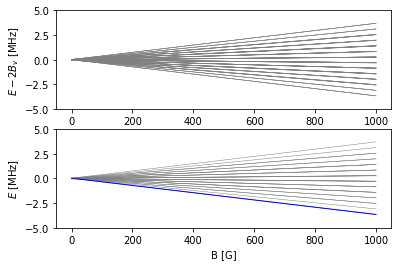

In [7]:
plt.close()
plt.figure(1)
B0 = p['B']
ax2 = plt.subplot(211)
pt2 = ax2.plot(B0,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
# pt_gs = ax2.plot(B0,Egs-2*Bv,color='blue',linewidth=0.5)
plt.ylim(-5,5)
plt.ylabel('$E - 2B_v$ [MHz]')
ax1 = plt.subplot(212)
pt = ax1.plot(B0,E0/1e3,color='gray',linewidth=0.5)
# pt_gs = ax1.plot(B0,Egs/1e3,color='blue',linewidth=1)
pt_gs = ax1.plot(B0,E0[:,0]/1e3,color='blue',linewidth=1)
plt.ylim(-5,5)
plt.xlabel('B [G]')
plt.ylabel('$E$ [MHz]')
# plt.xlim(0,80)

### Consider light shifts



#### Estimate trap depth for ground state NaCs.

For 1064nm trap, polarizability for Cs is 1163$a_0^3$, while NaCs is 936$a_0^3$. For Cs, have roughly 1mK/V in terms of servo setpoint. We typically create the g.s. molecules at 0.25V --> 250$\mu$K trap for Cs, which corresponds to roughly 200$\mu$K for NaCs. With 20MHz/mK, that corresponds to ~4MHz in frequency units.

#### Differential light shift with linear polarization as in the experiment right now

In [8]:
p = p0.copy()
p['E_td_00'] = np.linspace(0,5000,100)
p['B'] = np.linspace(864,864,1)
p['trap_pol'] = np.array([[0],[1],[0]])
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)

Text(0, 0.5, '|N=1> differential shift [MHz]')

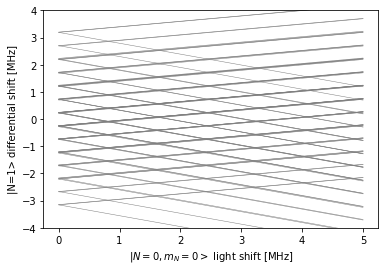

In [9]:
plt.close()
plt.figure(1)
x = p['E_td_00']/1e3
plt.plot(x,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
plt.ylim(-4,4)
plt.xlabel('$|N=0,m_N=0>$ light shift [MHz]')
plt.ylabel('|N=1> differential shift [MHz]')

#### Microwave transfer pathways with linearly polarized trap (5 MHz)

In [21]:
p = p0.copy()
p['E_td_00'] = np.linspace(5000,5000,1)
p['B'] = np.linspace(864,864,1)
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)

In [22]:
calc_uwave(E0,Ev0,b_uc,[['m_i1',1.5],['m_i2',2.5],['n',0],['m_n',0]])

Ev index: 29
     m_i1  m_i2    n  m_n     amps
120   1.5   2.5  0.0  0.0  0.99982
92    0.5   3.5  0.0  0.0 -0.01899
     m_i1  m_i2    n  m_n   mF      sig-        pi      sig+      E [kHz]  rot  v_ind
121   1.5   2.5  1.0 -1.0  3.0  -0.40854   0.00000   0.40792     0.000000 -1.0     30
122   1.5   2.5  1.0  0.0  4.0  -0.00000  -0.57715  -0.00000  2993.228490  0.0     73
123   1.5   2.5  1.0  1.0  5.0  -0.40773  -0.00000  -0.40842  3004.292392  1.0     55
127   1.5   3.5  1.0  1.0  6.0  -0.00000   0.01177  -0.00000  2514.300297  1.0     64
118   1.5   1.5  1.0  0.0  3.0   0.00903   0.00000   0.00691  3468.189505  0.0     68
126   1.5   3.5  1.0  0.0  5.0  -0.00760  -0.00000  -0.00517  2522.364668  0.0     47
119   1.5   1.5  1.0  1.0  4.0   0.00000  -0.00719   0.00000  3492.150555  1.0     86
57   -0.5   2.5  1.0 -1.0  1.0  -0.00135   0.00000  -0.00493  1916.572868 -1.0     40
91    0.5   2.5  1.0  1.0  4.0   0.00000  -0.00503   0.00000  3957.928690  1.0    100
115   1.5   0.5  1.0  

Up-leg $\pi$-transition 

In [12]:
calc_uwave(E0,Ev0,b_uc,[['m_i1',1.5],['m_i2',2.5],['n',1],['m_n',0]])

Ev index: 73
     m_i1  m_i2    n  m_n      amps
122   1.5   2.5  1.0  0.0 -0.999508
94    0.5   3.5  1.0  0.0  0.017471
125   1.5   3.5  1.0 -1.0 -0.016321
127   1.5   3.5  1.0  1.0 -0.012396
117   1.5   1.5  1.0 -1.0 -0.010420
     m_i1  m_i2    n  m_n   mF      sig-        pi      sig+      E [kHz]  rot  v_ind
120   1.5   2.5  0.0  0.0  4.0   0.00000  -0.57715   0.00000  -963.154867  0.0     29
124   1.5   3.5  0.0  0.0  5.0   0.00716   0.00000   0.00942 -1446.604421  0.0    127
116   1.5   1.5  0.0  0.0  3.0  -0.00411  -0.00000  -0.00615  -479.653879  0.0     27
88    0.5   2.5  0.0  0.0  3.0  -0.00187   0.00000  -0.00522     0.000000  0.0     26


In [13]:
disp_vec(b_uc, Ev0, [['m_i1',1.5],['m_i2',3.5],['n',0],['m_n',0]])    

Ev index: 127
     m_i1  m_i2    n  m_n  amps
124   1.5   3.5  0.0  0.0   1.0


127

Up-leg $\sigma$-transition

In [14]:
calc_uwave(E0,Ev0,b_uc,83)

Ev index: 83
     m_i1  m_i2    n  m_n      amps
90    0.5   2.5  1.0  0.0 -0.995299
115   1.5   0.5  1.0  1.0  0.062167
113   1.5   0.5  1.0 -1.0  0.062135
118   1.5   1.5  1.0  0.0 -0.023663
62   -0.5   3.5  1.0  0.0  0.021451
93    0.5   3.5  1.0 -1.0 -0.014955
85    0.5   1.5  1.0 -1.0 -0.012056
95    0.5   3.5  1.0  1.0 -0.011152
     m_i1  m_i2    n  m_n   mF      sig-        pi      sig+     E [kHz]  rot  v_ind
88    0.5   2.5  0.0  0.0  3.0   0.00000  -0.57493  -0.00000   -3.897269  0.0     26
112   1.5   0.5  0.0  0.0  2.0  -0.03602  -0.00000  -0.03605    0.000000  0.0     12
92    0.5   3.5  0.0  0.0  4.0  -0.00639  -0.00000  -0.00856 -491.349598  0.0     28
84    0.5   1.5  0.0  0.0  2.0   0.00411  -0.00000   0.00598  483.574117  0.0     23
120   1.5   2.5  0.0  0.0  4.0  -0.00244  -0.00000  -0.00401 -967.052136  0.0     29


In [15]:
calc_uwave(E0,Ev0,b_uc,33)

Ev index: 33
     m_i1  m_i2    n  m_n      amps
125   1.5   3.5  1.0 -1.0  0.707823
127   1.5   3.5  1.0  1.0 -0.706346
     m_i1  m_i2    n  m_n   mF     sig-       pi      sig+  E [kHz]  rot  v_ind
124   1.5   3.5  0.0  0.0  5.0  0.40781  0.00000  -0.40866      0.0  0.0    127


Text(0, 0.5, '|N=1> differential shift [MHz]')

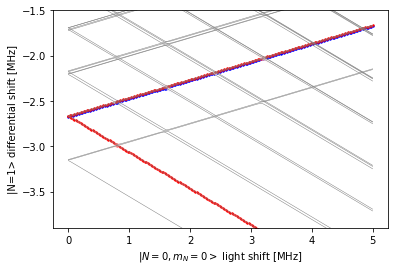

In [16]:
p = p0.copy()
p['E_td_00'] = np.linspace(0,5000,200)
p['B'] = np.linspace(864,864,1)
p['trap_pol'] = np.array([[0],[1],[0]])
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)

def color_map_blue(norm_val):
    return (1-np.exp(np.log(norm_val)),1-np.exp(np.log(norm_val)),1)
def color_map_red(norm_val):
    return (1,1-np.exp(np.log(norm_val)),1-np.exp(np.log(norm_val)))

dm_val = calc_uwave_vals(E0,Ev0,b_uc,[['m_i1',1.5],['m_i2',2.5],['n',0],['m_n',0]])
    
plt.close()
plt.figure(1)
x = p['E_td_00']/1e3
plt.plot(x,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
for i,xx in enumerate(x):
    dm_this = np.abs(dm_val[1][i,:])**2 # pi polarization for now
    dm_this = dm_this / np.max(dm_this)
    inds = np.argwhere(np.abs(dm_this) > 0.001)
    for j in inds:
        plt.scatter(xx,(E0[i,j]-2*p['Bv'])/1e3,color=color_map_blue(np.abs(dm_this)[j][0]),s=2)
for i,xx in enumerate(x):
#     dm_this = dm_val[0][i,:] # sig polarization
    dd = np.abs(dm_val[0][i,:])**2+np.abs(dm_val[2][i,:])**2
    dd = dd / np.max(dd)
    inds = np.argwhere(dd > 0.001)
    for j in inds:
        plt.scatter(xx,(E0[i,j]-2*p['Bv'])/1e3,color=color_map_red(np.abs(dd)[j][0]),s=2)        
plt.ylim(-3.9,-1.5)
plt.xlabel('$|N=0,m_N=0>$ light shift [MHz]')
plt.ylabel('|N=1> differential shift [MHz]')


#### With optimal elliptical polarization
Since we only have the option of polarization in xy-plane (no $\pi$), use the matrix elements with elliptical polarization. Magic angle is given by $\cos(2\gamma)=1/3$.

In [17]:
p = p0.copy()
p['E_td_00'] = np.linspace(0,5000,100)
p['B'] = np.linspace(866,866,1)
p['trap_pol'] = np.array([[np.cos(np.arccos(1/3)/2)],[1j*np.sin(np.arccos(1/3)/2)],[0]])
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)

Text(0, 0.5, '|N=1> differential shift [MHz]')

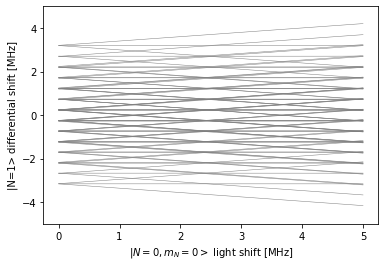

In [18]:
plt.close()
plt.figure(1)
x = p['E_td_00']/1e3
plt.plot(x,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
# pt_gs = ax2.plot(B0,Egs-2*Bv,color='blue',linewidth=0.5)
plt.ylim(-5,5)
plt.xlabel('$|N=0,m_N=0>$ light shift [MHz]')
plt.ylabel('|N=1> differential shift [MHz]')

The differential light shift of states $\propto |1,1>-|1,-1>$ are flat.

#### Microwave pathways with optimal polarization

In [16]:
p = p0.copy()
p['E_td_00'] = np.linspace(5000,5000,1)
p['B'] = np.linspace(866,866,1)
p['trap_pol'] = np.array([[np.cos(np.arccos(1/3)/2)],[1j*np.sin(np.arccos(1/3)/2)],[0]])
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)

In [17]:
calc_uwave(E0,Ev0,b_uc,[['m_i1',1.5],['m_i2',2.5],['n',0],['m_n',0]])

Ev index: 29
     m_i1  m_i2    n  m_n      amps
120   1.5   2.5  0.0  0.0 -0.999821
92    0.5   3.5  0.0  0.0  0.018945
     m_i1  m_i2    n  m_n   mF      sig-        pi      sig+      E [kHz]  rot  v_ind
121   1.5   2.5  1.0 -1.0  3.0  -0.40916  -0.00000  -0.40727     0.000000  1.0     30
122   1.5   2.5  1.0  0.0  4.0   0.00000   0.56194  -0.00000  1993.976573  0.0     69
123   1.5   2.5  1.0  1.0  5.0   0.39472  -0.00000  -0.39506  1003.157201 -1.0     34
115   1.5   0.5  1.0  1.0  3.0   0.10009  -0.00000  -0.10638   973.971253  1.0     35
89    0.5   2.5  1.0 -1.0  2.0  -0.00000   0.12831   0.00000  1957.801488 -1.0     67
83    0.5   0.5  1.0  1.0  2.0  -0.00000  -0.03144   0.00000  1936.731574  1.0     66
126   1.5   3.5  1.0  0.0  5.0   0.00381  -0.00000  -0.00783  1521.387435  0.0     41
117   1.5   1.5  1.0 -1.0  2.0  -0.00000  -0.00697   0.00000  1492.444974 -1.0     60
57   -0.5   2.5  1.0 -1.0  1.0   0.00547  -0.00000  -0.00193  1921.227725  1.0     49
89    0.5   2.5  1.

We want the "-1" state for the rotational state.

In [19]:
calc_uwave(E0,Ev0,b_uc,34)

Ev index: 34
     m_i1  m_i2    n  m_n      amps
123   1.5   2.5  1.0  1.0  0.684129
121   1.5   2.5  1.0 -1.0 -0.683534
113   1.5   0.5  1.0 -1.0  0.183893
115   1.5   0.5  1.0  1.0  0.173596
126   1.5   3.5  1.0  0.0  0.014115
93    0.5   3.5  1.0 -1.0  0.013724
95    0.5   3.5  1.0  1.0 -0.013570
     m_i1  m_i2    n  m_n   mF      sig-        pi      sig+      E [kHz]  rot  v_ind
120   1.5   2.5  0.0  0.0  4.0   0.39506  -0.00000  -0.39472  -969.318928  0.0     29
112   1.5   0.5  0.0  0.0  2.0   0.10028   0.00000   0.10622     0.000000  0.0     12
124   1.5   3.5  0.0  0.0  5.0   0.00000   0.00815   0.00000 -1453.902065  0.0    127
56   -0.5   2.5  0.0  0.0  2.0  -0.00532   0.00000  -0.00187   961.417635  0.0     20
116   1.5   1.5  0.0  0.0  3.0   0.00000   0.00374   0.00000  -484.684485  0.0     27


In [20]:
disp_ind(E0,Ev0,b_uc,34)

NameError: name 'disp_ind' is not defined

Text(0, 0.5, '|N=1> differential shift [MHz]')

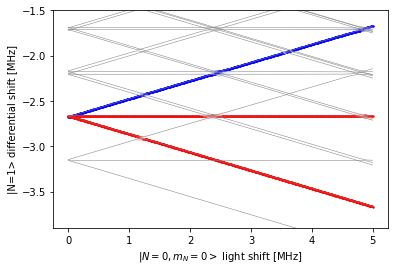

In [22]:
p = p0.copy()
p['E_td_00'] = np.linspace(0,5000,500)
p['B'] = np.linspace(864,864,1)
p['trap_pol'] = np.array([[np.cos(np.arccos(1/3)/2)],[1j*np.sin(np.arccos(1/3)/2)],[0]])
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)

def color_map_blue(norm_val):
    return (1-np.exp(np.log(norm_val)),1-np.exp(np.log(norm_val)),1)
def color_map_red(norm_val):
    return (1,1-np.exp(np.log(norm_val)),1-np.exp(np.log(norm_val)))

dm_val = calc_uwave_vals(E0,Ev0,b_uc,[['m_i1',1.5],['m_i2',2.5],['n',0],['m_n',0]])
    
plt.close()
plt.figure(1)
x = p['E_td_00']/1e3
plt.plot(x,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
for i,xx in enumerate(x):
    dm_this = np.abs(dm_val[1][i,:])**2 # pi polarization for now
    dm_this = dm_this / np.max(dm_this)
    inds = np.argwhere(np.abs(dm_this) > 0.001)
    for j in inds:
        plt.scatter(xx,(E0[i,j]-2*p['Bv'])/1e3,color=color_map_blue(np.abs(dm_this)[j][0]),s=2)
for i,xx in enumerate(x):
#     dm_this = dm_val[0][i,:] # sig polarization
    dd = np.abs(dm_val[0][i,:])**2+np.abs(dm_val[2][i,:])**2
    dd = dd / np.max(dd)
    inds = np.argwhere(dd > 0.001)
    for j in inds:
        plt.scatter(xx,(E0[i,j]-2*p['Bv'])/1e3,color=color_map_red(np.abs(dd)[j][0]),s=2)        
plt.ylim(-3.9,-1.5)

plt.xlabel('$|N=0,m_N=0>$ light shift [MHz]')
plt.ylabel('|N=1> differential shift [MHz]')

In [37]:
p = p0.copy()
p['E_td_00'] = np.linspace(3500,3500,1)
p['B'] = np.linspace(864,864,1)
p['trap_pol'] = np.array([[np.cos(np.arccos(1/3)/2)],[1j*np.sin(np.arccos(1/3)/2)],[0]])
# p['trap_pol'] = np.array([[0],[1],[0]])
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)

In [38]:
calc_uwave(E0,Ev0,b_uc,[['m_i1',1.5],['m_i2',2.5],['n',0],['m_n',0]])

Ev index: 29
     m_i1  m_i2    n  m_n     amps
120   1.5   2.5  0.0  0.0 -0.99982
92    0.5   3.5  0.0  0.0  0.01899
     m_i1  m_i2    n  m_n   mF      sig-        pi      sig+      E [kHz]  rot  v_ind
121   1.5   2.5  1.0 -1.0  3.0  -0.40955   0.00000  -0.40685     0.000000  1.0     30
123   1.5   2.5  1.0  1.0  5.0   0.40646   0.00000  -0.40919   700.580901 -1.0     33
122   1.5   2.5  1.0  0.0  4.0   0.00000  -0.57660  -0.00000  1391.203388  0.0     61
126   1.5   3.5  1.0  0.0  5.0   0.01062  -0.00000  -0.01738   920.527864  0.0     36
91    0.5   2.5  1.0  1.0  4.0   0.00000  -0.01840  -0.00000  1654.417416 -1.0     68
119   1.5   1.5  1.0  1.0  4.0  -0.00000  -0.01778   0.00000  1188.418148 -1.0     53
113   1.5   0.5  1.0 -1.0  1.0  -0.01365   0.00000   0.00773   973.789516  1.0     38
89    0.5   2.5  1.0 -1.0  2.0   0.00000   0.01102  -0.00000   953.349429  1.0     51
61   -0.5   3.5  1.0 -1.0  2.0   0.00000   0.00630  -0.00000  1418.881357  1.0     62
118   1.5   1.5  1.0  

In [39]:
calc_uwave(E0,Ev0,b_uc,33)

Ev index: 33
     m_i1  m_i2    n  m_n      amps
123   1.5   2.5  1.0  1.0  0.708603
121   1.5   2.5  1.0 -1.0 -0.703847
126   1.5   3.5  1.0  0.0  0.034371
115   1.5   0.5  1.0  1.0 -0.023623
93    0.5   3.5  1.0 -1.0  0.014995
95    0.5   3.5  1.0  1.0 -0.013792
113   1.5   0.5  1.0 -1.0 -0.013290
     m_i1  m_i2    n  m_n   mF      sig-        pi      sig+      E [kHz]  rot  v_ind
120   1.5   2.5  0.0  0.0  4.0   0.40919   0.00000  -0.40646  -967.052136  0.0     29
124   1.5   3.5  0.0  0.0  5.0  -0.00000   0.01984  -0.00000 -1450.501690  0.0    127
112   1.5   0.5  0.0  0.0  2.0  -0.01364   0.00000  -0.00767     0.000000  0.0     12
56   -0.5   2.5  0.0  0.0  2.0  -0.00458  -0.00000  -0.00103   959.181736  0.0     19
116   1.5   1.5  0.0  0.0  3.0   0.00000  -0.00445   0.00000  -483.551149  0.0     27


In [44]:
p = p0.copy()
p['B'] = np.linspace(0,1000,100)
p['E_td_00'] = np.linspace(3500,3500,1)
p['trap_pol'] = np.array([[np.cos(np.arccos(1/3)/2)],[1j*np.sin(np.arccos(1/3)/2)],[0]])
H_B,_ = H_mol(p)

E0, Ev0 = calc_eig(H_B)

(-0.5, 0.5)

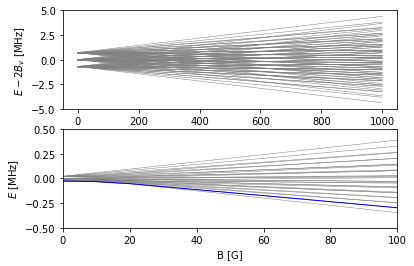

In [50]:
plt.close()
plt.figure(1)
B0 = p['B']
ax2 = plt.subplot(211)
pt2 = ax2.plot(B0,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
# pt_gs = ax2.plot(B0,Egs-2*Bv,color='blue',linewidth=0.5)
plt.ylim(-5,5)
plt.ylabel('$E - 2B_v$ [MHz]')
ax1 = plt.subplot(212)
pt = ax1.plot(B0,E0/1e3,color='gray',linewidth=0.5)
# pt_gs = ax1.plot(B0,Egs/1e3,color='blue',linewidth=1)
pt_gs = ax1.plot(B0,E0[:,1]/1e3,color='blue',linewidth=1)
plt.ylim(-5,5)
plt.xlabel('B [G]')
plt.ylabel('$E$ [MHz]')
plt.xlim(0,100)
plt.ylim(-.5,.5)

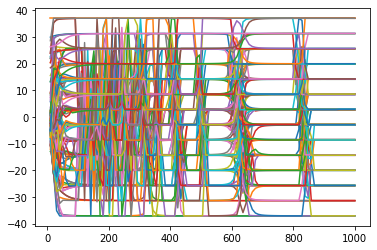

In [53]:
diff_E = E0[1:,:] - E0[0:-1,:]
plt.close()
plt.figure(5)
plt.plot(B0[1:],diff_E)

In [54]:
E0.shape

(100, 128)